In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')
true_landamarks = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')

CNN_full_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation.npy')
UNET_full_augmenatation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation.npy')

CNN_no_blur_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_no_blur_augmentation.npy')
UNET_no_blur_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_no_blur_augmentation.npy')

CNN_no_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_no_augmentation.npy')
UNET_no_augmentation = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_no_augmentation.npy')

CNN_50 = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation_50_.npy')
UNET_50 = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation_50.npy')

CNN_25 = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_CNN_full_augmentation_25.npy')
UNET_25 = np.load('/content/drive/MyDrive/Arlette/Model_Outputs/predictions_norm_UNET_full_augmentation_25.npy')

calculate erros

In [ ]:
height, width = 160, 320

# calculate landamrk mean pixel error
def landmark_mpe(y_true, y_pred, width, height):
    y_true_dn = y_true.copy()
    y_pred_dn = y_pred.copy()

    y_true_dn[:,:,0] *= width
    y_true_dn[:,:,1] *= height
    y_pred_dn[:,:,0] *= width
    y_pred_dn[:,:,1] *= height

    # euclidean distance per landmark
    return np.sqrt(np.sum((y_true_dn - y_pred_dn)**2, axis=2))  # (n, 18)

In [ ]:
# CNN mean pixel error
errors_CNN_full = landmark_mpe(true_landamarks, CNN_full_augmentation, width, height)
errors_CNN_no_blur = landmark_mpe(true_landamarks, CNN_no_blur_augmentation, width, height)
errors_CNN_none = landmark_mpe(true_landamarks, CNN_no_augmentation, width, height)
errors_CNN_50 = landmark_mpe(true_landamarks, CNN_50, width, height)
errors_CNN_25 = landmark_mpe(true_landamarks, CNN_25, width, height)

# UNet mean pixel errors
errors_UNET_full = landmark_mpe(true_landamarks, UNET_full_augmenatation, width, height)
errors_UNET_no_blur = landmark_mpe(true_landamarks, UNET_no_blur_augmentation, width, height)
errors_UNET_none = landmark_mpe(true_landamarks, UNET_no_augmentation, width, height)
errors_UNET_50 = landmark_mpe(true_landamarks, UNET_50, width, height)
errors_UNET_25 = landmark_mpe(true_landamarks, UNET_25, width, height)

# summarize all errors per model
errors_CNN_all = np.concatenate([errors_CNN_full, errors_CNN_no_blur, errors_CNN_none, errors_CNN_50, errors_CNN_25], axis=0)
errors_UNET_all = np.concatenate([errors_UNET_full, errors_UNET_no_blur, errors_UNET_none, errors_UNET_50, errors_UNET_25], axis=0)

boxplot mean pixel error per landmark for all experiments

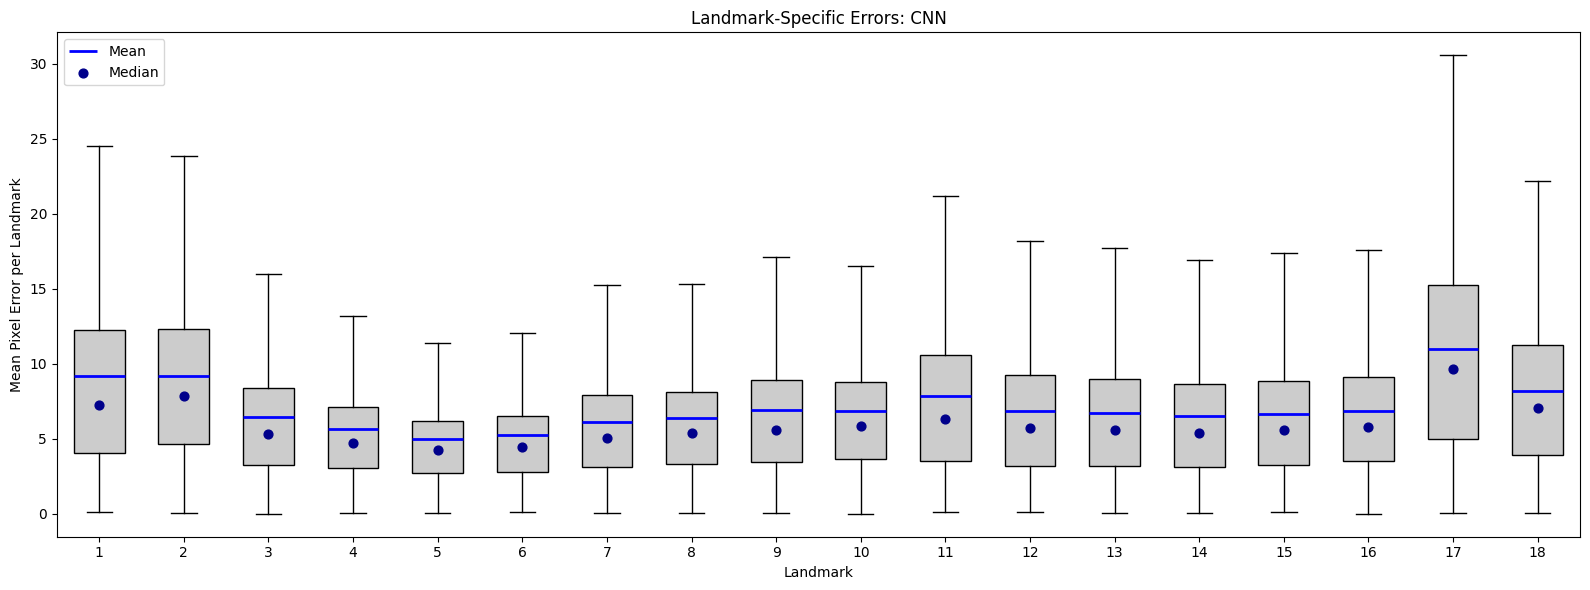

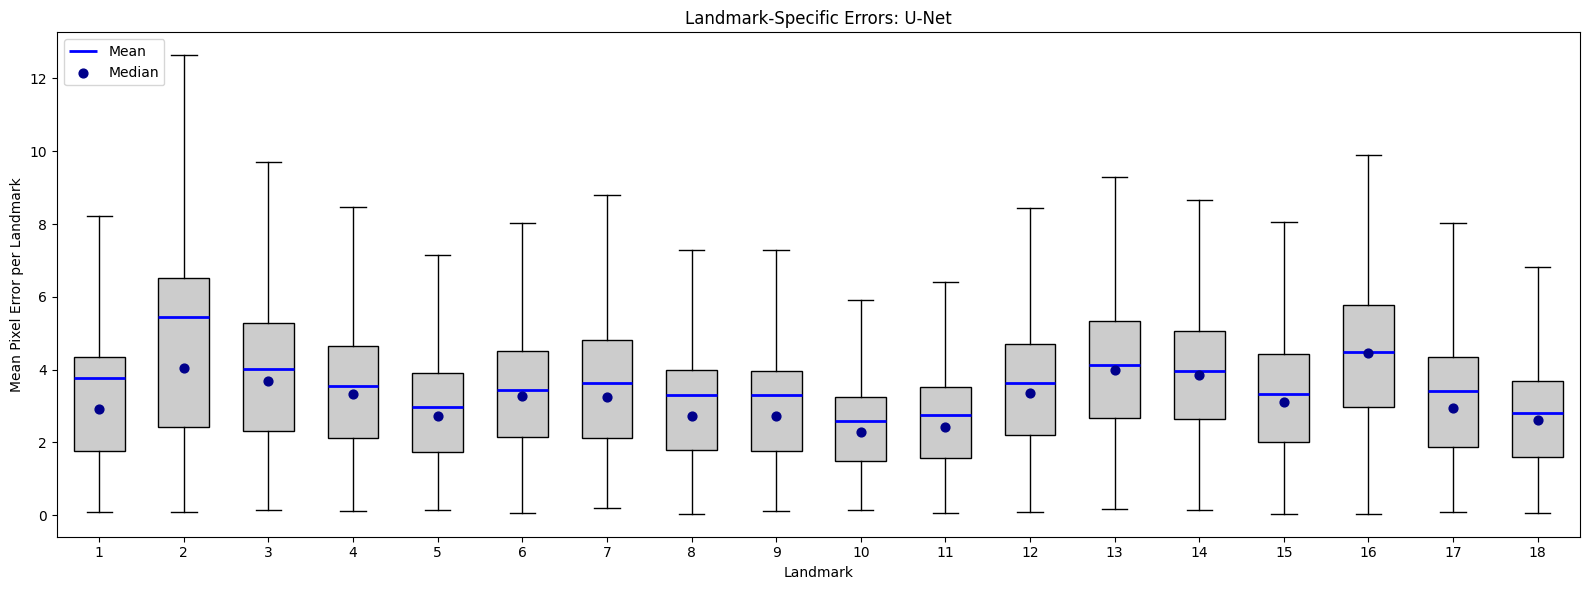

In [ ]:
models = ['CNN', 'U-Net']
errors_models = [errors_CNN_all, errors_UNET_all]

for model_name, errors_mpe in zip(models, errors_models):
    fig, ax = plt.subplots(figsize=(16,6))

    # boxplot per landmark
    box = ax.boxplot(
        [errors_mpe[:,i] for i in range(18)],
        patch_artist=True,
        widths=0.6,
        showfliers=False,
        medianprops=dict(color='white', linewidth=0)
    )

    # box grey
    for patch in box['boxes']:
        patch.set_facecolor('#CCCCCC')

    # mean as line
    for i in range(18):
        mean_val = np.mean(errors_mpe[:,i])
        x_left = i + 1 - 0.3
        x_right = i + 1 + 0.3
        ax.hlines(mean_val, x_left, x_right, color='blue', linewidth=2, label='Mean' if i==0 else "")

    # median as dot
    for i in range(18):
        median_val = np.median(errors_mpe[:,i])
        ax.scatter(i+1, median_val, color='darkblue', s=40, zorder=3, label='Median' if i==0 else "")

    ax.set_xticks(range(1,19))
    ax.set_xticklabels([str(i) for i in range(1,19)])
    ax.set_ylabel('Mean Pixel Error per Landmark')
    ax.set_xlabel('Landmark')
    ax.set_title(f'Landmark-Specific Errors: {model_name}')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

summarize error for each experiment

In [ ]:
# all experiments per model as dict
experiments_CNN = {"Full Aug": errors_CNN_full, "No Blur": errors_CNN_no_blur, "No Aug": errors_CNN_none, "50%": errors_CNN_50, "25%": errors_CNN_25}
experiments_UNET = {"Full Aug": errors_UNET_full, "No Blur": errors_UNET_no_blur, "No Aug": errors_UNET_none, "50%": errors_UNET_50, "25%": errors_UNET_25}

# summarize errors for each experiment
def summarize_errors(experiments, model_name):
    print(f"\n{model_name} Landmark MPE summary:\n")
    for exp_name, errors in experiments.items():
        print(f"Experiment: {exp_name}")
        for lm in range(errors.shape[1]):  # landmarks 0-17
            lm_errors = errors[:, lm]
            mean = np.mean(lm_errors)
            std = np.std(lm_errors)
            median = np.median(lm_errors)
            print(f"  Landmark {lm+1}: Mean ± SD = {mean:.2f} ± {std:.2f}, Median = {median:.2f}")
        print("\n" + "-"*50 + "\n")

In [ ]:
# CNN
summarize_errors(experiments_CNN, "CNN")

# U-Net
summarize_errors(experiments_UNET, "U-Net")


CNN Landmark MPE summary:

Experiment: Full Aug
  Landmark 1: Mean ± SD = 10.44 ± 7.53, Median = 8.63
  Landmark 2: Mean ± SD = 9.40 ± 6.18, Median = 8.29
  Landmark 3: Mean ± SD = 8.61 ± 6.06, Median = 7.25
  Landmark 4: Mean ± SD = 7.26 ± 5.38, Median = 6.19
  Landmark 5: Mean ± SD = 5.66 ± 4.72, Median = 4.85
  Landmark 6: Mean ± SD = 6.32 ± 5.03, Median = 5.33
  Landmark 7: Mean ± SD = 7.27 ± 5.30, Median = 6.15
  Landmark 8: Mean ± SD = 6.27 ± 4.85, Median = 5.19
  Landmark 9: Mean ± SD = 6.55 ± 5.15, Median = 5.35
  Landmark 10: Mean ± SD = 6.75 ± 4.74, Median = 5.72
  Landmark 11: Mean ± SD = 9.24 ± 6.65, Median = 7.64
  Landmark 12: Mean ± SD = 8.11 ± 5.78, Median = 6.96
  Landmark 13: Mean ± SD = 7.83 ± 5.63, Median = 6.65
  Landmark 14: Mean ± SD = 7.35 ± 5.26, Median = 6.25
  Landmark 15: Mean ± SD = 7.47 ± 5.32, Median = 6.34
  Landmark 16: Mean ± SD = 7.86 ± 5.32, Median = 6.89
  Landmark 17: Mean ± SD = 11.92 ± 7.99, Median = 10.61
  Landmark 18: Mean ± SD = 8.53 ± 5.84,

heatmaps for landamark error per model

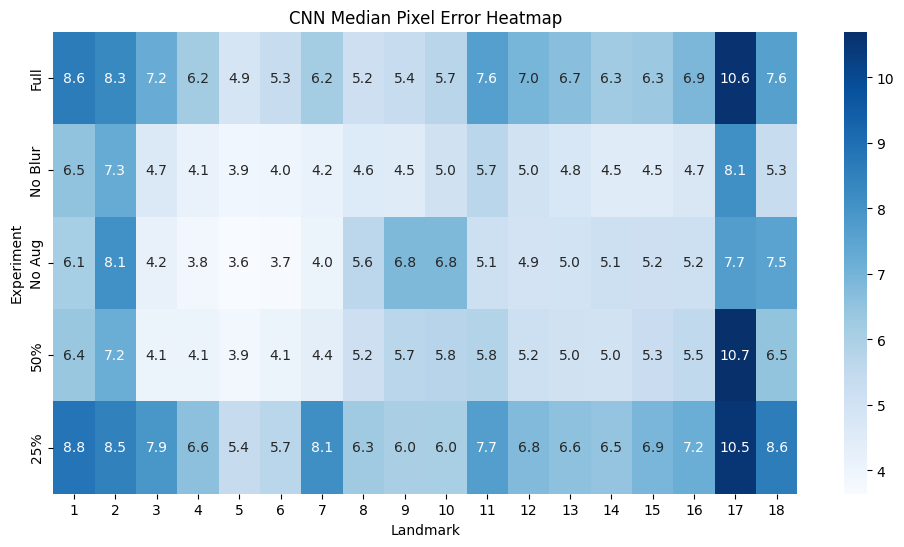

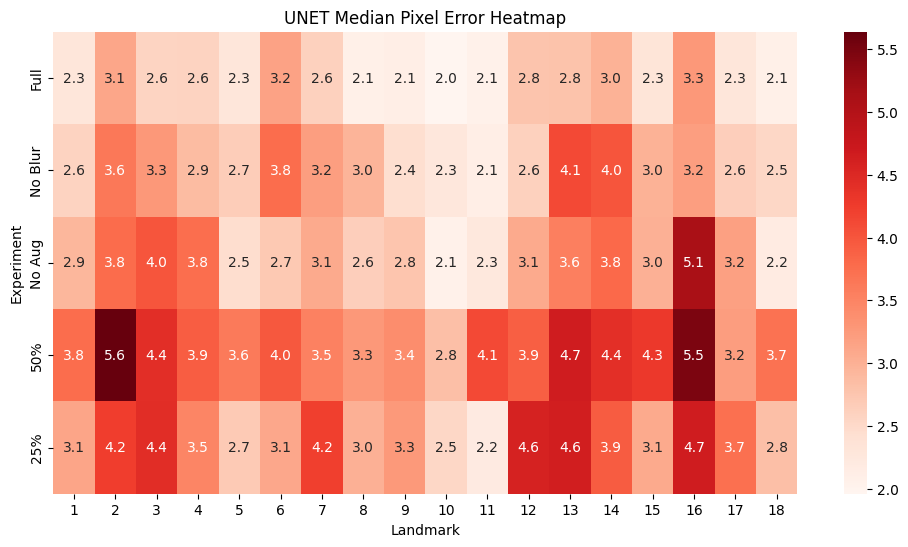

In [ ]:
experiments = ['Full', 'No Blur', 'No Aug', '50%', '25%']

errors_dict_CNN = {'Full': errors_CNN_full, 'No Blur': errors_CNN_no_blur, 'No Aug': errors_CNN_none, '50%': errors_CNN_50, '25%': errors_CNN_25}
errors_dict_UNET = {'Full': errors_UNET_full, 'No Blur': errors_UNET_no_blur, 'No Aug': errors_UNET_none, '50%': errors_UNET_50, '25%': errors_UNET_25}

# median mean pixel error per model
median_mpes_CNN = np.array([np.median(errors_dict_CNN[exp], axis=0) for exp in experiments])
median_mpes_UNET = np.array([np.median(errors_dict_UNET[exp], axis=0) for exp in experiments])

# heatmap CNN
plt.figure(figsize=(12,6))
sns.heatmap(median_mpes_CNN, annot=True, fmt=".1f", cmap='Blues', xticklabels=range(1,19), yticklabels=experiments)
plt.xlabel("Landmark")
plt.ylabel("Experiment")
plt.title("CNN Median Pixel Error Heatmap")
plt.show()

# heatmap UNet
plt.figure(figsize=(12,6))
sns.heatmap(median_mpes_UNET, annot=True, fmt=".1f", cmap='Reds', xticklabels=range(1,19), yticklabels=experiments)
plt.xlabel("Landmark")
plt.ylabel("Experiment")
plt.title("UNET Median Pixel Error Heatmap")
plt.show()


median mpe as table

In [ ]:
experiments = ['Full', 'No Blur', 'No Aug', '50%', '25%']

# median pixel error per landmark
median_mpes_CNN = np.array([np.median(errors_dict_CNN[exp], axis=0) for exp in experiments])
median_mpes_UNET = np.array([np.median(errors_dict_UNET[exp], axis=0) for exp in experiments])

# landmark labels
landmarks = [f'LM{i+1}' for i in range(median_mpes_CNN.shape[1])]

# df for CNN
df_CNN = pd.DataFrame(median_mpes_CNN, index=experiments, columns=landmarks)
df_CNN.index.name = "Experiment"

# df for UNet
df_UNET = pd.DataFrame(median_mpes_UNET, index=experiments, columns=landmarks)
df_UNET.index.name = "Experiment"

# table
print("CNN Median Pixel Error (MedPE) Table:")
print(df_CNN.round(2))

print("\nUNET Median Pixel Error (MedPE) Table:")
print(df_UNET.round(2))

CNN Median Pixel Error (MedPE) Table:
             LM1   LM2   LM3   LM4   LM5   LM6   LM7   LM8   LM9  LM10  LM11  \
Experiment                                                                     
Full        8.63  8.29  7.25  6.19  4.85  5.33  6.15  5.19  5.35  5.72  7.64   
No Blur     6.53  7.25  4.66  4.14  3.92  3.99  4.16  4.55  4.52  5.03  5.71   
No Aug      6.12  8.07  4.19  3.85  3.64  3.68  4.04  5.64  6.82  6.83  5.14   
50%         6.39  7.18  4.05  4.06  3.87  4.05  4.38  5.16  5.67  5.75  5.83   
25%         8.84  8.52  7.89  6.62  5.38  5.68  8.12  6.28  6.02  6.04  7.68   

            LM12  LM13  LM14  LM15  LM16   LM17  LM18  
Experiment                                             
Full        6.96  6.65  6.25  6.34  6.89  10.61  7.63  
No Blur     5.01  4.77  4.48  4.49  4.73   8.10  5.35  
No Aug      4.94  4.98  5.14  5.17  5.15   7.72  7.54  
50%         5.15  5.04  5.00  5.28  5.54  10.70  6.48  
25%         6.79  6.58  6.48  6.92  7.17  10.51  8.61  

UNET Med

boxplot mean pixel errors for standard experiment

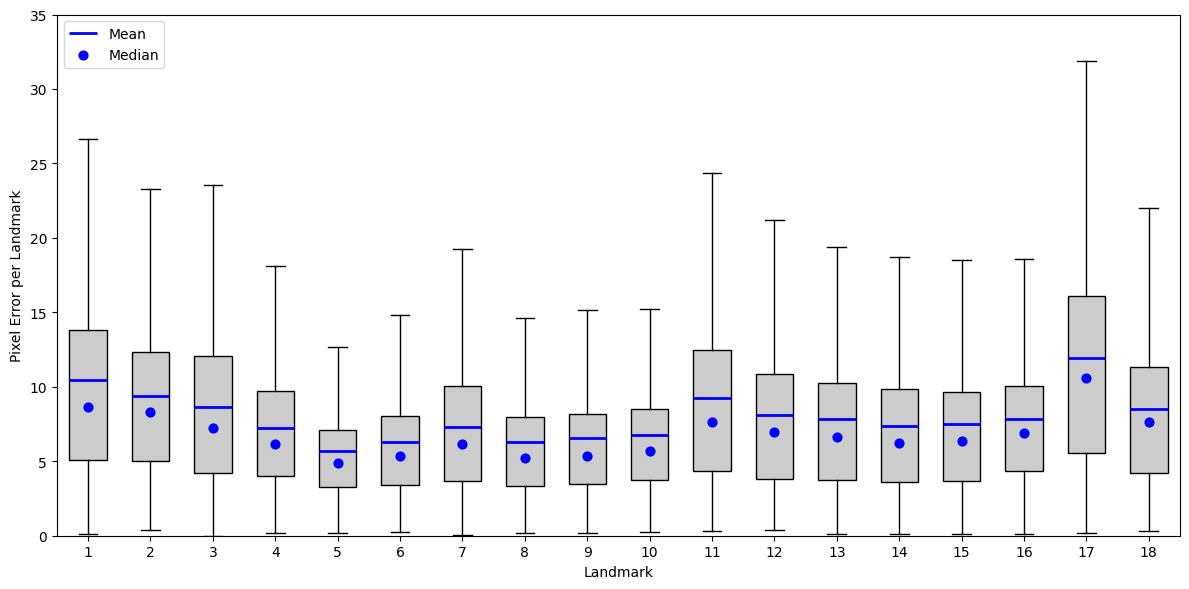

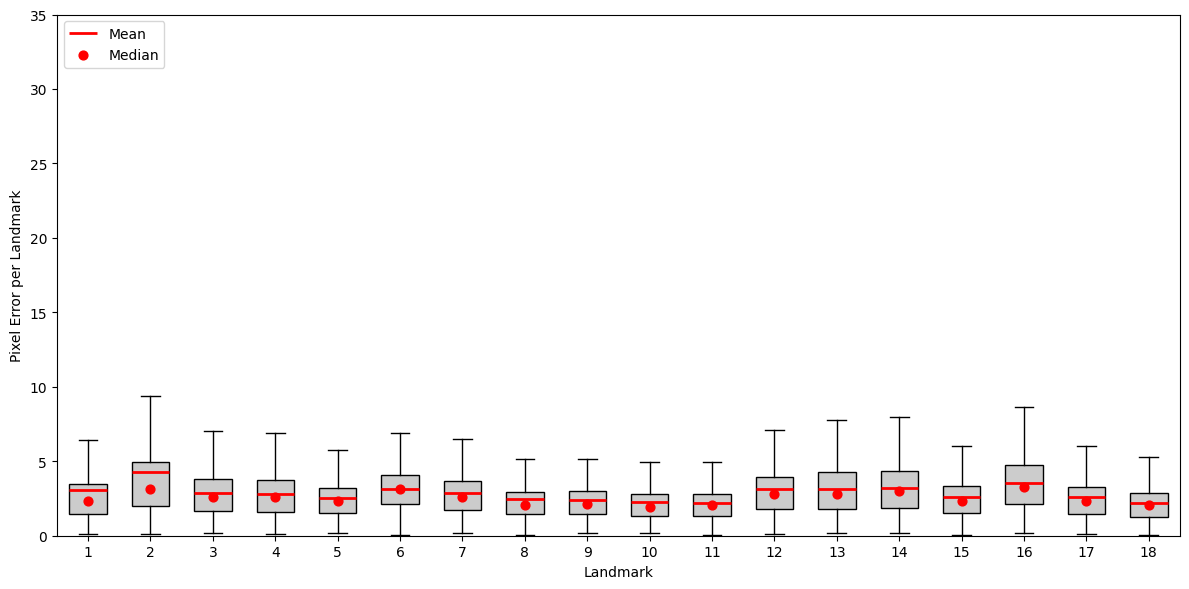

CNN Landmark Errors:
   Landmark  Median Pixel Error  Mean Pixel Error
0         1            8.632916         10.435374
1         2            8.291804          9.402877
2         3            7.245832          8.614882
3         4            6.185809          7.259072
4         5            4.854505          5.661755
5         6            5.325946          6.324931
6         7            6.151367          7.267129
7         8            5.186399          6.272419
8         9            5.354500          6.547007
9        10            5.721555          6.748645
10       11            7.640957          9.238823
11       12            6.963018          8.114334
12       13            6.651884          7.832789
13       14            6.250497          7.354929
14       15            6.343117          7.472065
15       16            6.891486          7.856955
16       17           10.609936         11.922659
17       18            7.626276          8.532389

UNet Landmark Errors:
   Lan

In [ ]:
height, width = 160, 320

# calculate euclidean distance per landmark
def landmark_mpe(y_true, y_pred, width, height):
    y_true_dn = y_true.copy()
    y_pred_dn = y_pred.copy()

    y_true_dn[:,:,0] *= width
    y_true_dn[:,:,1] *= height
    y_pred_dn[:,:,0] *= width
    y_pred_dn[:,:,1] *= height

    return np.sqrt(np.sum((y_true_dn - y_pred_dn)**2, axis=2))  # (n, 18)

# median and mean pixel error for standard experiment
median_CNN = np.median(errors_CNN_full, axis=0)
mean_CNN = np.mean(errors_CNN_full, axis=0)
median_UNET = np.median(errors_UNET_full, axis=0)
mean_UNET = np.mean(errors_UNET_full, axis=0)

# boxplot
models = ['CNN', 'U-Net']
errors_models = [errors_CNN_full, errors_UNET_full]
colors = ['blue', 'red']  # CNN=blue, UNET=red

y_min, y_max = 0, 35

for model_name, errors_mpe, color in zip(models, errors_models, colors):
    fig, ax = plt.subplots(figsize=(12,6))

    box = ax.boxplot(
        [errors_mpe[:,i] for i in range(18)],
        patch_artist=True,
        widths=0.6,
        showfliers=False,
        medianprops=dict(color='white', linewidth=0)
    )

    for patch in box['boxes']:
        patch.set_facecolor('#CCCCCC')

    # mean line
    for i in range(18):
        mean_val = np.mean(errors_mpe[:,i])
        x_left = i + 1 - 0.3
        x_right = i + 1 + 0.3
        ax.hlines(mean_val, x_left, x_right, color=color, linewidth=2, label='Mean' if i==0 else "")

    # median dot
    for i in range(18):
        median_val = np.median(errors_mpe[:,i])
        ax.scatter(i+1, median_val, color=color, s=40, zorder=3, label='Median' if i==0 else "")

    ax.set_xticks(range(1,19))
    ax.set_xticklabels([f'{i}' for i in range(1,19)])
    ax.set_ylabel('Pixel Error per Landmark')
    ax.set_xlabel('Landmark')
    ax.set_ylim(y_min, y_max)

    # legend manually
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')

    plt.tight_layout()
    plt.show()

# tables
cnn_table = pd.DataFrame({
    'Landmark': [f'{i}' for i in range(1,19)],
    'Median Pixel Error': median_CNN,
    'Mean Pixel Error': mean_CNN
})

unet_table = pd.DataFrame({
    'Landmark': [f'LM{i}' for i in range(1,19)],
    'Median Pixel Error': median_UNET,
    'Mean Pixel Error': mean_UNET
})

print("CNN Landmark Errors:")
print(cnn_table)
print("\nUNet Landmark Errors:")
print(unet_table)


In [ ]:
# median and mean pixel error for standard experiment
median_CNN = np.median(errors_CNN_full, axis=0)
mean_CNN = np.mean(errors_CNN_full, axis=0)
median_UNET = np.median(errors_UNET_full, axis=0)
mean_UNET = np.mean(errors_UNET_full, axis=0)

# calculate sd
sd_CNN = np.std(errors_CNN_full, axis=0)
sd_UNET = np.std(errors_UNET_full, axis=0)

# tables mean, median, sd
cnn_table = pd.DataFrame({'Landmark': [f'LM{i}' for i in range(1,19)], 'Median Pixel Error': median_CNN, 'Mean Pixel Error': mean_CNN, 'SD Pixel Error': sd_CNN})

unet_table = pd.DataFrame({'Landmark': [f'LM{i}' for i in range(1,19)], 'Median Pixel Error': median_UNET, 'Mean Pixel Error': mean_UNET, 'SD Pixel Error': sd_UNET})

print("CNN Landmark Errors:")
print(cnn_table)
print("\nUNet Landmark Errors:")
print(unet_table)

CNN Landmark Errors:
   Landmark  Median Pixel Error  Mean Pixel Error  SD Pixel Error
0       LM1            8.632916         10.435374        7.533188
1       LM2            8.291804          9.402877        6.179307
2       LM3            7.245832          8.614882        6.062780
3       LM4            6.185809          7.259072        5.384371
4       LM5            4.854505          5.661755        4.715315
5       LM6            5.325946          6.324931        5.029906
6       LM7            6.151367          7.267129        5.301352
7       LM8            5.186399          6.272419        4.846327
8       LM9            5.354500          6.547007        5.154138
9      LM10            5.721555          6.748645        4.740035
10     LM11            7.640957          9.238823        6.647222
11     LM12            6.963018          8.114334        5.776574
12     LM13            6.651884          7.832789        5.627743
13     LM14            6.250497          7.354929      

statistics

CNN

In [ ]:
from scipy.stats import friedmanchisquare, wilcoxon
# cnn trainingsconditions: mpe per landmark (n, 18)
cnn_conditions = [errors_CNN_full, errors_CNN_no_blur, errors_CNN_none, errors_CNN_50, errors_CNN_25]
cnn_labels = ["Full", "No Blur", "No Aug", "50%", "25%"]

# friedman test per landmark
for lm in range(18):
    # value for landmark over all conditions
    lm_values = [cond[:, lm] for cond in cnn_conditions]

    # friedman test
    stat, p = friedmanchisquare(*lm_values)
    print(f"CNN Landmark {lm+1} Friedman H={stat:.2f}, p={p:.3e}")

    # if friedman shows significance, post-hoc pairwise wilcoxon
    if p < 0.05:
        print("  Post-hoc Wilcoxon:")
        for i in range(len(lm_values)):
            for j in range(i+1, len(lm_values)):
                stat_w, p_w = wilcoxon(lm_values[i], lm_values[j])
                print(f"    {cnn_labels[i]} vs {cnn_labels[j]}: p={p_w:.3e}")

CNN Landmark 1 Friedman H=568.22, p=1.168e-121
  Post-hoc Wilcoxon:
    Full vs No Blur: p=6.068e-63
    Full vs No Aug: p=2.476e-51
    Full vs 50%: p=8.011e-40
    Full vs 25%: p=2.598e-11
    No Blur vs No Aug: p=3.045e-03
    No Blur vs 50%: p=1.239e-02
    No Blur vs 25%: p=1.512e-66
    No Aug vs 50%: p=7.107e-04
    No Aug vs 25%: p=9.272e-59
    50% vs 25%: p=5.646e-65
CNN Landmark 2 Friedman H=202.95, p=8.737e-43
  Post-hoc Wilcoxon:
    Full vs No Blur: p=5.463e-29
    Full vs No Aug: p=5.589e-02
    Full vs 50%: p=3.279e-08
    Full vs 25%: p=3.185e-03
    No Blur vs No Aug: p=2.189e-29
    No Blur vs 50%: p=3.635e-02
    No Blur vs 25%: p=2.530e-24
    No Aug vs 50%: p=4.253e-05
    No Aug vs 25%: p=7.141e-02
    50% vs 25%: p=1.622e-22
CNN Landmark 3 Friedman H=907.90, p=3.242e-195
  Post-hoc Wilcoxon:
    Full vs No Blur: p=4.126e-66
    Full vs No Aug: p=3.055e-83
    Full vs 50%: p=5.559e-94
    Full vs 25%: p=1.768e-01
    No Blur vs No Aug: p=1.315e-08
    No Blur vs 

UNET

In [ ]:
unet_conditions = [errors_UNET_full, errors_UNET_no_blur, errors_UNET_none, errors_UNET_50, errors_UNET_25]
unet_labels = ["Full", "No Blur", "No Aug", "50%", "25%"]

for lm in range(18):
    lm_values = [cond[:, lm] for cond in unet_conditions]
    stat, p = friedmanchisquare(*lm_values)
    print(f"U-Net Landmark {lm+1} Friedman H={stat:.2f}, p={p:.3e}")

    if p < 0.05:
        print("  Post-hoc Wilcoxon:")
        for i in range(len(lm_values)):
            for j in range(i+1, len(lm_values)):
                stat_w, p_w = wilcoxon(lm_values[i], lm_values[j])
                print(f"    {unet_labels[i]} vs {unet_labels[j]}: p={p_w:.3e}")


U-Net Landmark 1 Friedman H=355.04, p=1.435e-75
  Post-hoc Wilcoxon:
    Full vs No Blur: p=5.883e-05
    Full vs No Aug: p=2.029e-14
    Full vs 50%: p=1.211e-55
    Full vs 25%: p=3.685e-34
    No Blur vs No Aug: p=1.840e-06
    No Blur vs 50%: p=3.407e-43
    No Blur vs 25%: p=1.173e-21
    No Aug vs 50%: p=2.628e-23
    No Aug vs 25%: p=3.794e-09
    50% vs 25%: p=1.822e-04
U-Net Landmark 2 Friedman H=499.36, p=9.197e-107
  Post-hoc Wilcoxon:
    Full vs No Blur: p=4.031e-09
    Full vs No Aug: p=1.260e-09
    Full vs 50%: p=1.248e-71
    Full vs 25%: p=2.942e-28
    No Blur vs No Aug: p=4.525e-01
    No Blur vs 50%: p=4.255e-50
    No Blur vs 25%: p=1.744e-10
    No Aug vs 50%: p=2.285e-45
    No Aug vs 25%: p=2.402e-09
    50% vs 25%: p=4.659e-19
U-Net Landmark 3 Friedman H=513.76, p=7.087e-110
  Post-hoc Wilcoxon:
    Full vs No Blur: p=2.806e-13
    Full vs No Aug: p=2.853e-52
    Full vs 50%: p=1.517e-66
    Full vs 25%: p=7.316e-68
    No Blur vs No Aug: p=5.748e-19
    No Bl

overall model comparison: CNN vs UNet

In [ ]:
#test that unets predict in general lower values than cnns

# median pixel error per sample
def compute_median_errors(true, pred, width=320, height=160):
    true_scaled = true.copy()
    pred_scaled = pred.copy()
    true_scaled[...,0] *= width
    true_scaled[...,1] *= height
    pred_scaled[...,0] *= width
    pred_scaled[...,1] *= height
    errors = np.sqrt(np.sum((true_scaled - pred_scaled)**2, axis=2))
    return np.median(errors, axis=1)  # median over landamarks per sample

# all experiments
experiments = [("CNN", CNN_full_augmentation, UNET_full_augmenatation), ("No Blur", CNN_no_blur_augmentation, UNET_no_blur_augmentation), ("No Aug", CNN_no_augmentation, UNET_no_augmentation), ("50%", CNN_50, UNET_50), ("25%", CNN_25, UNET_25)]

# get median errors
cnn_medians_all = []
unet_medians_all = []

for name, cnn_pred, unet_pred in experiments:
    cnn_medians_all.append(compute_median_errors(true_landamarks, cnn_pred))
    unet_medians_all.append(compute_median_errors(true_landamarks, unet_pred))

cnn_medians_all = np.concatenate(cnn_medians_all)
unet_medians_all = np.concatenate(unet_medians_all)

# wilcoxon for paired samples
stat, p_value = wilcoxon(cnn_medians_all, unet_medians_all)
print(f"Wilcoxon signed-rank test: stat={stat}, p-value={p_value}")

# get overall median
print(f"Overall Median Pixel Error: CNN = {np.median(cnn_medians_all):.2f}, UNet = {np.median(unet_medians_all):.2f}")

Wilcoxon signed-rank test: stat=455394.0, p-value=0.0
Overall Median Pixel Error: CNN = 5.63, UNet = 3.13
